C:\Users\samto\AppData\Local\Temp\ipykernel_8096\4263891592.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequence = torch.tensor(sequence).float()
C:\Users\samto\AppData\Local\Temp\ipykernel_8096\4263891592.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).float().view(-1, 1)


Epoch 1 loss: 0.7062770128250122
Epoch 26 loss: 0.6621111631393433
Epoch 51 loss: 0.44521045684814453
Epoch 76 loss: 0.5233991146087646
Epoch 101 loss: 0.4339694380760193
Epoch 126 loss: 0.48480725288391113
Accuracy: 0.6957
Precision: 0.7436
Recall: 0.8788
F1: 0.8056
Confusion Matrix:
[[ 3 10]
 [ 4 29]]


C:\Users\samto\AppData\Local\Temp\ipykernel_8096\4263891592.py:116: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequence = torch.tensor(sequence).float()


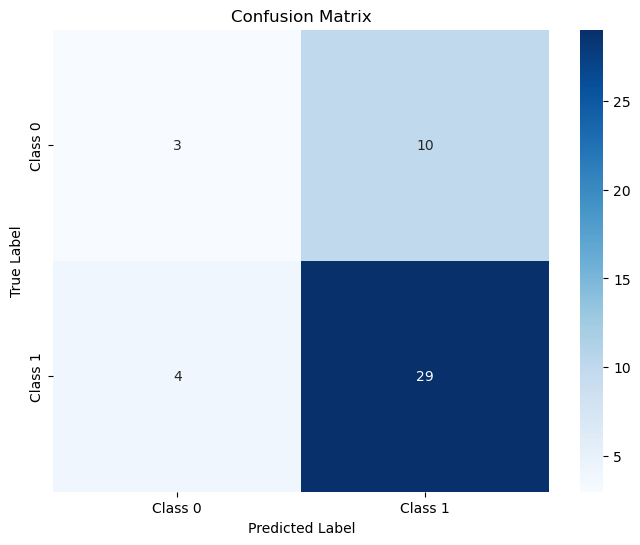

In [46]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
import pandas as pd
import tkinter as tk
from tkinter import filedialog
import pandas_ta as ta
from sklearn.model_selection import TimeSeriesSplit
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

root = tk.Tk()
root.wm_attributes('-topmost', 1)
root.withdraw()

# model, data prep, and model run

# normalize data and assign movement direction values
def prep(dataset):
    scaler = StandardScaler()

    dataset['RSI (14D)'] = ta.rsi(dataset['Close'], length=14)
    dataset['20 Day CCI'] = ta.cci(high=dataset['High'], low=dataset['Low'], 
                                    close=dataset['Close'], length=20)
    dataset['Williams %R'] = ta.willr(high=dataset['High'], low=dataset['Low'], 
                                        close=dataset['Close'], length=14)
    dataset['EMA (5D)'] = dataset['Close'].ewm(span=5, adjust=False).mean()

    features = ['Open', 'High', 'Low', 'Close', 'Volume', 'RSI (14D)', 
                '20 Day CCI', 'Williams %R', 'Mortgage_rate', 'Unemp_rate',
                'disposable_income', 'Personal_consumption_expenditure', 
                'personal_savings']
    
    dataset[features] = dataset[features].astype(float)
    dataset[features] = scaler.fit_transform(dataset[features])

    dataset['MA10'] = dataset['Close'].rolling(window=10).mean()
    dataset['MA50'] = dataset['Close'].rolling(window=50).mean()

    dataset['Target'] = np.where(dataset['Close'].shift(-1) > dataset['Close'], 1, 0)
    prepared_data = dataset.dropna()

    return prepared_data, scaler

# create LSTM model class
class LSTM_Model(nn.Module):
    def __init__(self, input_layer, hidden_layer, output_layer):
        super(LSTM_Model, self).__init__()
        self.hidden_layer = hidden_layer
        self.lstm = nn.LSTM(input_layer, hidden_layer, batch_first=True)
        self.linear_layer = nn.Linear(hidden_layer, output_layer)
        self.hidden_cell = (torch.zeros(1, 1, self.hidden_layer),
                            torch.zeros(1, 1, self.hidden_layer))

    # Define the forward pass of the LSTM_Model
    def forward(self, input_tensor):
        self.hidden_cell = (torch.zeros(1, input_tensor.size(0), self.hidden_layer), 
                            torch.zeros(1, input_tensor.size(0), self.hidden_layer))
        
        # Pass the input through the LSTM layer
        out, self.hidden_cell = self.lstm(input_tensor, self.hidden_cell)
        
        # Get the output of the last time step
        lstm_out_last = out[:, -1, :]
        
        # Pass the output through the linear layer
        linear_out = self.linear_layer(lstm_out_last)
        
        return linear_out

# create sequences for input data and corresponding labels
def create_sequence(input_data, sequence_length):
  sequences = []
  for i in range(len(input_data) - sequence_length):
    sequence = input_data[i : i + sequence_length, :-1]
    label = input_data[i + sequence_length, -1]
    sequences.append((sequence, label))
  return sequences

# train the model with data provided
def trainer(model, train_data, loss_func, opt, epochs):
  for epoch in range(epochs):
    for sequence, labels, in train_data:
      opt.zero_grad()
      model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer),
                           torch.zeros(1, 1, model.hidden_layer))
      
      sequence = torch.tensor(sequence).float()
      labels = torch.tensor(labels).float().view(-1, 1)

      # Initialize the hidden state at the start of each sequence
      model.hidden_cell = (torch.zeros(1, sequence.size(0), 
                                       model.hidden_layer),
                            torch.zeros(1, sequence.size(0), 
                                        model.hidden_layer))

      y = model(sequence)
      loss = loss_func(y, labels)
      loss.backward()
      opt.step()

    # print progress as the model runs
    if epoch % 25 == 1:
      print(f'Epoch {epoch} loss: {loss.item()}')

# make predictions using trained model
def predictor(model, test_data):
    model.eval()
    with torch.no_grad():
        predictions = []
        for sequence, _ in test_data:
            sequence = torch.tensor(sequence).float()

            # Initialize the hidden state at the start of each sequence
            model.hidden_cell = (torch.zeros(1, sequence.size(0), 
                                             model.hidden_layer),
                                 torch.zeros(1, sequence.size(0), 
                                             model.hidden_layer))
            
            y = model(sequence)

            batch_predictions = torch.round(torch.sigmoid(y))

            predictions.extend(batch_predictions.squeeze().tolist())

    return predictions

# load and prep data

# get dataset
file_path = filedialog.askopenfilename(parent=root, title="Select A File")
ticker = pd.read_csv(file_path)
ticker, scaler = prep(ticker)

# create sequences
sequence_length = 7
sequences = create_sequence(ticker[['Open', 'High', 'Low', 'Close', 'Volume', 'RSI (14D)', 
                '20 Day CCI', 'Williams %R', 'Mortgage_rate', 'Unemp_rate',
                'disposable_income', 'Personal_consumption_expenditure', 
                'personal_savings', 'MA10', 'MA50', 'Target']].values, sequence_length)

# split test/train and create dataloader
train_size = int(len(sequences) * 0.8) # set train size
train_sequences = sequences[ : train_size]
test_sequences = sequences[train_size : ]

train_data = torch.utils.data.DataLoader(train_sequences, shuffle=True, batch_size=10)
test_data = torch.utils.data.DataLoader(test_sequences, shuffle=True, batch_size=10)

# initialise mode
model = LSTM_Model(input_layer=15, hidden_layer=50, output_layer=1)
loss_func = nn.BCEWithLogitsLoss() # is this the best one?
opt = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.03)

# train
epochs = 150 # is this optimal?
trainer(model, train_data, loss_func, opt, epochs)

# run model and predict values
test_labels = [label for _, label in test_sequences]
predictions = predictor(model, test_data)

# calcluate statistics
accuracy = accuracy_score(test_labels, predictions)
cm = confusion_matrix(test_labels, predictions)
pres = precision_score(test_labels, predictions)
rec = recall_score(test_labels, predictions)
f1 = f1_score(test_labels, predictions)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {pres:.4f}')
print(f'Recall: {rec:.4f}')
print(f'F1: {f1:.4f}')
print(f'Confusion Matrix:\n{cm}')

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0', 'Class 1'], 
            yticklabels=['Class 0', 'Class 1'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

